In [1]:
import numpy as np
import camb
import matplotlib.pyplot as plt
from onepower import Spectra

from defaults_dictionary import kwargs

from matplotlib import rc

rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)

plt.rcParams.update({'font.size': 16})

In [2]:
# Common parameters
# -----------------------

omega_m = 0.25       # Total matter density (cold dark matter + baryonic matter)
omega_c = 0.2      # Cold dark matter density
omega_b = 0.05      # Baryonic matter density

h0 = 0.7            # Dimensionless Hubble parameter
ns = 0.9            # Spectral index

m_nu = 0.06
n_nu = 3.044

k_lower = -4 # k-range [h/Mpc]
k_upper = 1  # k-range [h/Mpc]

# CAMB settings
# -----------------------
# Cosmology
camb_cosmo = {
    'omch2': omega_c * h0 ** 2, # - m_nu/93.14,  # Omega_c * h^2 (CDM density)
    'ombh2': omega_b * h0 ** 2,  # Omega_b * h^2 (baryon density)
    'omk': 0.0,
    'H0': h0 * 100,              # Hubble constant in km/s/Mpc
    'ns': ns,                    # Spectral index
    'As': 2.7e-9,                # Scalar amplitude
#    'num_massive_neutrinos': 3,  # Effective number of massive neutrinos
    'mnu': m_nu,                 # Sum of neutrino masses in eV
    'omk': 0.0,
    'neutrino_hierarchy': 'degenerate',
    'nnu': n_nu,
    'standard_neutrino_neff': n_nu,
    'TCMB': 2.7255,
}
camb_de = {
    'w': -1.0,
    'wa': 0.0,
}

# Redshift and k-range settings
z = np.linspace(0,3,100)
kmin = 10 ** k_lower
kmax = 10 ** k_upper
nk = 100 #5000

# OnePower settings
# -----------------------------
# Cosmology
params_cosmo = {
    'omega_c': omega_c,    # Cold dark matter density
#    'omega_m': omega_m,    # Total matter density
    'omega_b': omega_b,    # Baryonic matter density
    'h0': h0,              # Dimensionless Hubble parameter
    'n_s': ns,             # Spectral index (note different key name than CAMB)
#    'sigma_8': 0.8,        # RMS linear density fluctuation in 8 Mpc/h spheres
    'm_nu': m_nu,          # Neutrino mass
    'tcmb': 2.7255,
    'w0': -1.0,
    'wa': 0.0,
}

# Power Spectrum
params_pk = {
#    'k_vec': np.logspace(k_lower, k_upper, nk),
    'lnk_min': float(np.log(10**(k_lower))),
    'lnk_max': float(np.log(10**(k_upper))),
    'dlnk': 0.01, #float((np.log(10**(k_upper)) - np.log(10**(k_lower))) / nk),
    'z_vec': np.array([0.0]),
}

In [3]:
def compute_growth_factor(r, z, k, kmax):

    P_tot = r.get_matter_power_interpolator(nonlinear=False, extrap_kmax=kmax)

#    Evaluate it at the smallest k
    kmin = k.min()
    P_kmin = P_tot.P(z, kmin)

    D = np.sqrt(P_kmin / P_kmin[0]).squeeze()
    return np.atleast_1d(D)

Note: redshifts have been re-sorted (earliest first)


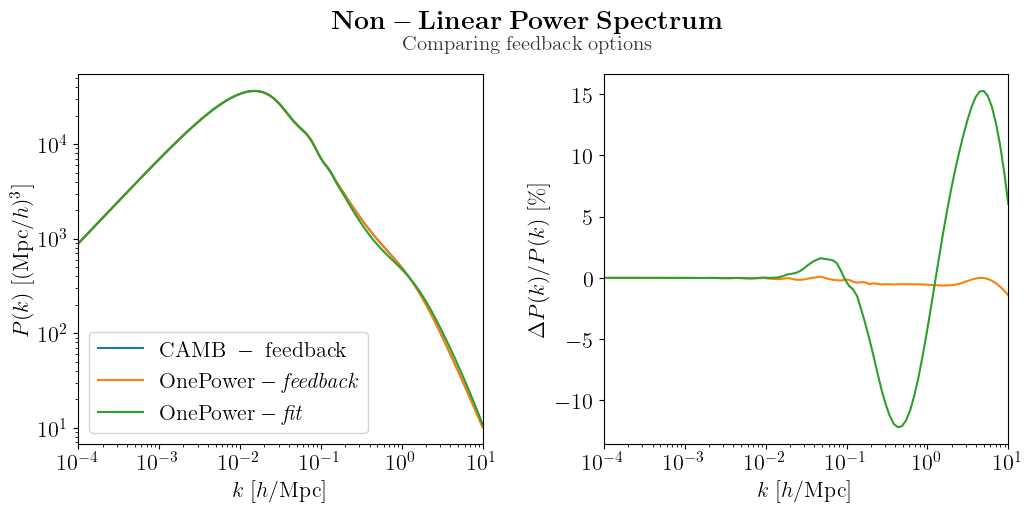

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.3,hspace=0.5)

# =================================================================================
# CAMB Power Spectrum
# =================================================================================

cp = camb.set_params(HMCode_logT_AGN=7.8,
    **camb_cosmo,
    halofit_version='mead2020_feedback')
cp.set_dark_energy(**camb_de)

cp.set_matter_power(redshifts=z, kmax=kmax, nonlinear=True)

results = camb.get_results(cp)
powerspec = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints=nk)
kh, z_, camb_pk_nl = powerspec

ax1.plot(kh, camb_pk_nl[0],
		 c='#1f77b4', label=r"$\mathrm{CAMB\ -\ feedback}$")

# =================================================================================
# Transfer Function from CAMB (for Onepower)
# =================================================================================

camb_transfers = camb.get_transfer_functions(cp)
transfer_func = results.get_matter_transfer_data().transfer_z('delta_tot', -1)
transfer_k = results.get_matter_transfer_data().transfer_z('k/h', -1)
camb_growth = compute_growth_factor(results, z_, kh, kmax)

# =================================================================================
# Onepower Power Spectrum
# =================================================================================

model_feedback = Spectra(
        sigma_8=results.get_sigma8_0(),
        transfer_model='FromArray',
        transfer_params={'k': transfer_k, 'T': transfer_func},
        growth_model='FromArray',
        growth_params={'z': z, 'd': camb_growth},
        dewiggle=True,
        **params_cosmo, **params_pk, **kwargs,
        k_vec=kh,
        mead_correction='feedback')

ax1.plot(model_feedback.k_vec, model_feedback.power_spectrum_mm.pk_tot[0,0,:],
		 c='#ff7f0e', label=r"$\mathrm{OnePower} - \mathit{feedback}$")

model_fit = Spectra(
        sigma_8=results.get_sigma8_0(),
        transfer_model='FromArray',
        transfer_params={'k': transfer_k, 'T': transfer_func},
        growth_model='FromArray',
        growth_params={'z': z, 'd': camb_growth},
        dewiggle=True,
        **params_cosmo, **params_pk, **kwargs,
        k_vec=kh,
        mead_correction='fit')

ax1.plot(model_fit.k_vec, model_fit.power_spectrum_mm.pk_tot[0,0,:],
		 c='#2ca02c', label=r"$\mathrm{OnePower} - \mathit{fit}$")

# =================================================================================
# Relative Difference
# =================================================================================

diff = (model_feedback.power_spectrum_mm.pk_tot[0,0,:]
		- camb_pk_nl[0])/camb_pk_nl[0]

ax2.plot(kh, diff * 100, c='#ff7f0e')

diff = (model_fit.power_spectrum_mm.pk_tot[0,0,:]
		- camb_pk_nl[0])/camb_pk_nl[0]

ax2.plot(kh, diff * 100, c='#2ca02c')


ax1.legend()

ax1.set(xlim=(10.0**k_lower, 10.0**k_upper),
        xscale='log',
        yscale='log',
        xlabel=r"$k \ [h/\mathrm{Mpc}]$",
        ylabel=r"$P(k) \ [(\mathrm{Mpc}/h)^3]$")

ax2.set(xlim=(10.0**k_lower, 10.0**k_upper),
        xscale='log',
        xlabel=r"$k \ [h/\mathrm{Mpc}]$",
        ylabel=r"$\Delta P(k) / P(k)\ [\%]$")

fig.suptitle(r"$\mathbf{Non-Linear\ Power\ Spectrum}$")

fig.text(0.5, 0.9, r"$\mathrm{Comparing\ feedback\ options}$",
         fontsize=15, ha='center', alpha=0.8)

fig.subplots_adjust(top=0.85)

plt.savefig("Pk_Nonlinear_feedback1.pdf",
            bbox_inches='tight',
            dpi=300)

plt.show()

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


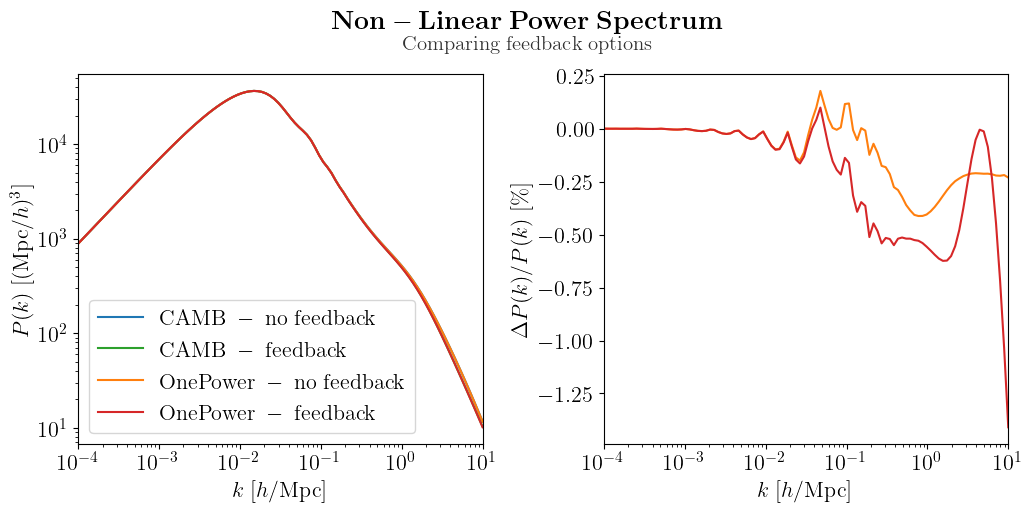

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.3,hspace=0.5)

# =================================================================================
# No feedback
# =================================================================================

cp = camb.set_params(HMCode_logT_AGN=7.8,
    **camb_cosmo,
    halofit_version='mead2020')
cp.set_dark_energy(**camb_de)

cp.set_matter_power(redshifts=z, kmax=kmax, nonlinear=True)

results = camb.get_results(cp)
powerspec = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints=nk)
kh, z_, camb_pk_nl = powerspec

ax1.plot(kh, camb_pk_nl[0],
		 c='#1f77b4', label=r"$\mathrm{CAMB\ -\ no \ feedback}$")

# ---

camb_transfers = camb.get_transfer_functions(cp)
transfer_func = results.get_matter_transfer_data().transfer_z('delta_tot', -1)
transfer_k = results.get_matter_transfer_data().transfer_z('k/h', -1)
camb_growth = compute_growth_factor(results, z_, kh, kmax)

# ---

model_nofeedback = Spectra(
        sigma_8=results.get_sigma8_0(),
        transfer_model='FromArray',
        transfer_params={'k': transfer_k, 'T': transfer_func},
        growth_model='FromArray',
        growth_params={'z': z, 'd': camb_growth},
        dewiggle=True,
        **params_cosmo, **params_pk, **kwargs,
        k_vec=kh,
        mead_correction='nofeedback')

# ---

diff = (model_nofeedback.power_spectrum_mm.pk_tot[0,0,:]
		- camb_pk_nl[0])/camb_pk_nl[0]

ax2.plot(kh, diff * 100, c='#ff7f0e')

# =================================================================================
# With feedback
# =================================================================================

cp = camb.set_params(HMCode_logT_AGN=7.8,
    **camb_cosmo,
    halofit_version='mead2020_feedback')
cp.set_dark_energy(**camb_de)

cp.set_matter_power(redshifts=z, kmax=kmax, nonlinear=True)

results = camb.get_results(cp)
powerspec = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints=nk)
kh, z_, camb_pk_nl = powerspec

ax1.plot(kh, camb_pk_nl[0],
         c='#2ca02c', label=r"$\mathrm{CAMB\ -\ feedback}$")

# ---

camb_transfers = camb.get_transfer_functions(cp)
transfer_func = results.get_matter_transfer_data().transfer_z('delta_tot', -1)
transfer_k = results.get_matter_transfer_data().transfer_z('k/h', -1)
camb_growth = compute_growth_factor(results, z_, kh, kmax)

# ---

model_feedback = Spectra(
        sigma_8=results.get_sigma8_0(),
        transfer_model='FromArray',
        transfer_params={'k': transfer_k, 'T': transfer_func},
        growth_model='FromArray',
        growth_params={'z': z, 'd': camb_growth},
        dewiggle=True,
        **params_cosmo, **params_pk, **kwargs,
        k_vec=kh,
        mead_correction='feedback')
# ---

diff = (model_feedback.power_spectrum_mm.pk_tot[0,0,:]
		- camb_pk_nl[0])/camb_pk_nl[0]

ax2.plot(kh, diff * 100, c='#d62728')

# ---

ax1.plot(model_nofeedback.k_vec,
		 model_nofeedback.power_spectrum_mm.pk_tot[0,0,:],
		 c='#ff7f0e', label=r"$\mathrm{OnePower\ -\ no\ feedback}$")
ax1.plot(model_feedback.k_vec,
		 model_feedback.power_spectrum_mm.pk_tot[0,0,:],
		 c='#d62728', label=r"$\mathrm{OnePower\ -\ feedback}$")


ax1.legend()

ax1.set(xlim=(10.0**k_lower, 10.0**k_upper),
        xscale='log',
        yscale='log',
        xlabel=r"$k \ [h/\mathrm{Mpc}]$",
        ylabel=r"$P(k) \ [(\mathrm{Mpc}/h)^3]$")

ax2.set(xlim=(10.0**k_lower, 10.0**k_upper),
        xscale='log',
        xlabel=r"$k \ [h/\mathrm{Mpc}]$",
        ylabel=r"$\Delta P(k) / P(k)\ [\%]$")

fig.suptitle(r"$\mathbf{Non-Linear\ Power\ Spectrum}$")

fig.text(0.5, 0.9, r"$\mathrm{Comparing\ feedback\ options}$",
         fontsize=15, ha='center', alpha=0.8)

fig.subplots_adjust(top=0.85)

plt.savefig("Pk_Nonlinear_feedback2.pdf",
            bbox_inches='tight',
            dpi=300)

plt.show()


Note: redshifts have been re-sorted (earliest first)


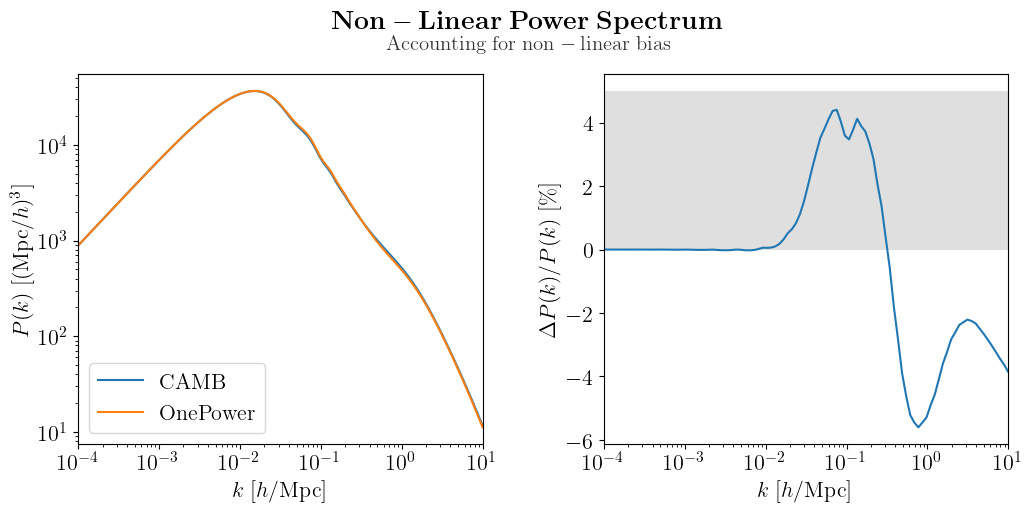

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.3,hspace=0.5)

# =================================================================================
# CAMB Power Spectrum
# =================================================================================

cp = camb.set_params(
    **camb_cosmo,
    halofit_version='mead2020')
cp.set_dark_energy(**camb_de)

cp.set_matter_power(redshifts=z, kmax=kmax, nonlinear=True)

results = camb.get_results(cp)
powerspec = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints=nk)
kh, z_, camb_pk_nl = powerspec

ax1.plot(kh, camb_pk_nl[0], label=r"$\mathrm{CAMB}$")

# =================================================================================
# Transfer Function from CAMB (for Onepower)
# =================================================================================

camb_transfers = camb.get_transfer_functions(cp)
transfer_func = results.get_matter_transfer_data().transfer_z('delta_tot', -1)
transfer_k = results.get_matter_transfer_data().transfer_z('k/h', -1)
camb_growth = compute_growth_factor(results, z_, kh, kmax)

# =================================================================================
# Onepower Power Spectrum
# =================================================================================

model_bnl = Spectra(
        sigma_8=results.get_sigma8_0(),
        transfer_model='FromArray',
        transfer_params={'k': transfer_k, 'T': transfer_func},
        growth_model='FromArray',
        growth_params={'z': z, 'd': camb_growth},
        bnl=True,
        dewiggle=True,
#        norm_cen=1.5,
        **params_cosmo, **params_pk, **kwargs,
        k_vec=kh,
        mead_correction='nofeedback')

ax1.plot(model_bnl.k_vec, model_bnl.power_spectrum_mm.pk_tot[0,0,:],
		 label=r"$\mathrm{OnePower}$")

# =================================================================================
# Relative Difference
# =================================================================================

diff = (model_bnl.power_spectrum_mm.pk_tot[0,0,:]
		- camb_pk_nl[0])/camb_pk_nl[0]

ax2.axhspan(0.0, 5.0, facecolor='gray', alpha=0.25)

ax2.plot(kh, diff * 100)


ax1.legend()

ax1.set(xlim=(10.0**k_lower, 10.0**k_upper),
        xscale='log',
        yscale='log',
        xlabel=r"$k \ [h/\mathrm{Mpc}]$",
        ylabel=r"$P(k) \ [(\mathrm{Mpc}/h)^3]$")

ax2.set(xlim=(10.0**k_lower, 10.0**k_upper),
        xscale='log',
        xlabel=r"$k \ [h/\mathrm{Mpc}]$",
        ylabel=r"$\Delta P(k) / P(k)\ [\%]$")

fig.suptitle(r"$\mathbf{Non-Linear\ Power\ Spectrum}$")

fig.text(0.5, 0.9, r"$\mathrm{Accounting\ for\ non-linear\ bias}$",
         fontsize=15, ha='center', alpha=0.8)

fig.subplots_adjust(top=0.85)

plt.savefig("Pk_Nonlinear_bnl.pdf",
            bbox_inches='tight',
            dpi=300)

plt.show()